In [1]:
%load_ext autoreload
%autoreload 2
from astropy.io import fits
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import utils

from dataset import SunImageDataset

In [2]:
isinstance(1, int)

True

In [3]:
dl = SunImageDataset(correct_sensor_data=True, in_types=['ew'], out_types=['0171', '0304'])
#dl.read_all_images(dl.save_folder, dl.save_name, out_types=['0304'], new_size=(864, 864), remake=True, folder_indices=[1200, 15000])

In [1]:
sample = dl[0:10]
print(sample['in'].shape)
print(sample['out'].shape)
print(np.min(sample['in'], axis=(0, 2, 3)))
mins = np.min(sample['out'], axis=(0, 2, 3))
sums = np.sum(sample['out'], axis=(0, 2, 3))
print(mins)
print(sums)
cat = np.concatenate((mins[:, None], sums[:, None]), axis=1)
mins = np.min(cat, axis=1)
print((mins[:, :, :, :] +sample['out']).shape)



NameError: name 'dl' is not defined

ew


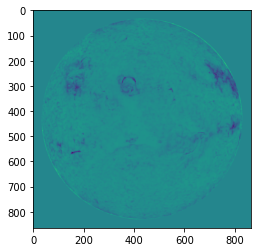

0304
Min: -2.94e+01 Max: 5.04e+04
Scale Min: -9.24e+02 Scale Max: 1.58e+06
2013-06-25 16:19:12


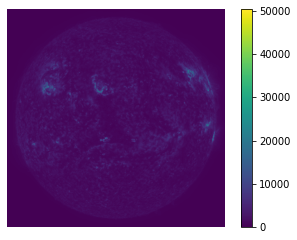

In [10]:
idx = 20
sample = dl[idx]
print('ew')
plt.imshow(sample['in'][0])
plt.show()
for img_type, i in zip(['0171', '0304'], [0, 1]):
    if i > 0:
        data = sample['out'][i]
        print(img_type)
        scale_val = 1/dl.get_interpolation_value(dl.get_date(idx))
        print('Min: {0:.2e} Max: {1:.2e}'.format(np.min(data), np.max(data)))
        print('Scale Min: {0:.2e} Scale Max: {1:.2e}'.format(np.min(data) * scale_val, np.max(data) * scale_val))
        plt.imshow(data)
        plt.colorbar()
        #plt.show()
        plt.axis('off')
        plt.savefig('example_linear_scale.png', dpi=300)
        
#print('0304')
#plt.imshow(sample['out'][1])
#plt.show()
print(pd.to_datetime(dl.get_date(idx) * 10 ** 9))


2013-06-25 16:20:00
ew


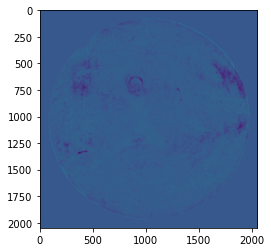

0304
Min: -3.88e+00 Max: 1.61e+03


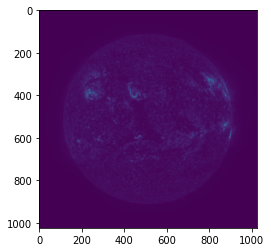

0171
Min: -2.75e+00 Max: 6.12e+03


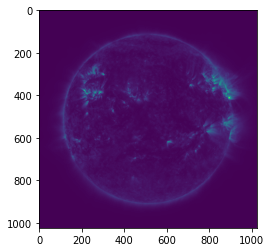

In [42]:
i = 0
for folder in dl.processed_path.iterdir():
    if i == idx:
        entry_date = pd.to_datetime(folder.parts[-1], format="%Y-%m-%d-H%H-M%M")
        print(entry_date)
        for file in [x for x in folder.iterdir() if x.suffix == '.gz' or x.suffix == '.fits']:
            filename = file.parts[-1]

            #Get the image type
            image_type = None
            if file.suffix == '.gz':
                filename = filename[0:-7]
            else:
                filename = filename[0:-5]
            types = filename.split('_')
            if len(types) > 1:
                image_type = types[-1]
            else:
                image_type = 'color'

            if image_type == 'ew':
                print(image_type)
                with fits.open(file) as hdulist:
                    hdulist[0].verify('fix')
                    plt.imshow(hdulist[0].data)
                    plt.show()
            if image_type == '0171' or image_type == '0304':
                print(image_type)
                with fits.open(file) as hdulist:
                    hdulist[1].verify('fix')
                    data = hdulist[1].data
                    print('Min: {0:.2e} Max: {1:.2e}'.format(np.min(data), np.max(data)))
                    plt.imshow(data)
                    plt.show()
        break
    else:
        i += 1

In [6]:
import h5py
with h5py.File(dl.save_folder / 'temp.h5', 'a') as hf:
    dates = hf['date'][:]
excluded_dates = list(map(lambda x: pd.to_datetime(x, format="%Y-%m-%d-H%H-M%M").value / 10 ** 9, dl.excluded_dates))
for date in dates:
    matching_times = list(filter(lambda x: np.abs(x) < 100, list(map(lambda x: x - date, excluded_dates))))
    #print(len(matching_times))
#print(len(excluded_dates))

sample = dl[list(range(1221))]
print(sample['in'].shape)
print(sample['out'].shape)


NameError: name 'dl' is not defined

In [9]:
#dl.processed_path
dl = SunImageDataset(correct_sensor_data=True, in_types=['ew'], out_types=['0171', '0304'])
num_images, num_quality = 0, 0
qualities, exptimes, dataskew, datakurt, datasum, missvals = [], [], [], [], [], []
for folder in dl.processed_path.iterdir():
    for file in [x for x in folder.iterdir() if x.suffix == '.gz' or x.suffix == '.fits']:
        filename = file.parts[-1]

        #Get the image type
        image_type = None
        if file.suffix == '.gz':
            filename = filename[0:-7]
        else:
            filename = filename[0:-5]
        types = filename.split('_')
        if len(types) > 1:
            image_type = types[-1]
        else:
            image_type = 'color'

        if image_type == '0304':
            image_date = pd.to_datetime(filename, format="AIA%Y%m%d_%H%M_" + image_type)
            image_card_id, check_quality = 1, True
            
            try:
                with fits.open(file) as hdulist:
                    hdulist[image_card_id].verify('fix')
                    #print(hdulist[image_card_id].header)
                    quality = hdulist[image_card_id].header['QUALITY']
                    qualities.append(quality)
                    exptimes.append(hdulist[image_card_id].header['EXPTIME'])
                    dataskew.append(hdulist[image_card_id].header['DATASKEW'])
                    datakurt.append(hdulist[image_card_id].header['DATAKURT'])
                    datasum.append(int(hdulist[image_card_id].header['DATASUM']))
                    missvals.append(hdulist[image_card_id].header['MISSVALS'])
                    if quality == 0:
                        num_quality += 1
                    num_images += 1
                    #print("Num Images: {0} Num Good Quality: {1}".format(num_images, num_quality))
            except OSError:
                print("Unable to read file :" + str(file))
    
            


Unable to read file :../datasets/processed/2013-02-26-H18-M25/AIA20130226_1824_0304.fits


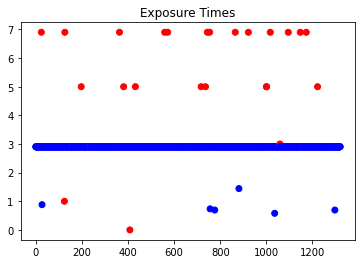

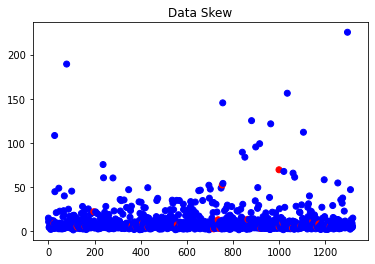

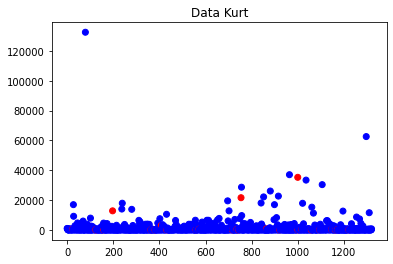

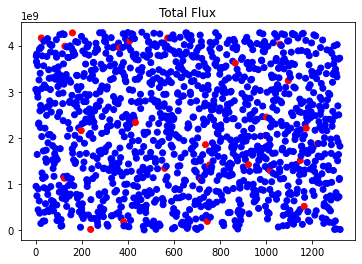

In [10]:
import matplotlib.pyplot as plt

potential_bad = []
n_images = len(qualities)
for i in range(n_images):
    if qualities[i] != 0: #or np.abs(exptimes[i]-3) > 1 #or missvals[i] > 0:
        potential_bad.append(i)
colors = []
for i in range(n_images):
    if i in potential_bad:
        colors.append('red')
    else:
        colors.append('blue')
    

x = list(range(len(exptimes)))
plt.title('Exposure Times')
plt.scatter(x=x, y=exptimes, c=colors)
plt.show()
x = list(range(len(dataskew)))
plt.title('Data Skew')
plt.scatter(x=x, y=dataskew, c=colors)
plt.show()
x = list(range(len(datakurt)))
plt.title('Data Kurt')
plt.scatter(x=x, y=datakurt, c=colors)
plt.show()
x = list(range(len(datasum)))
plt.title('Total Flux')
plt.scatter(x=x, y=datasum, c=colors)
plt.show()

In [2]:
#print(np.std(dl.x_data))
dl = SunImageDataset(correct_sensor_data=True, in_types=['ew'], out_types=['0171'])
#print(dl.shape)
#print(dl.y_data.shape)
#print(dl.dates_data.shape)

In [3]:
sample = dl[range(400)]
x_arr = sample['in'].reshape(-1)
y_arr = sample['out'].reshape(-1)

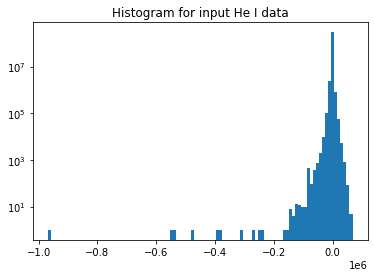

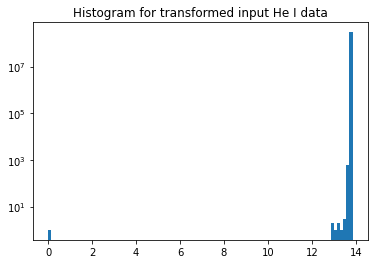

In [51]:
from scipy import stats

transformed_x_arr = np.log(x_arr - np.min(x_arr)+1)
plt.hist(x_arr, bins=100)
plt.title("Histogram for input He I data")
plt.yscale('log', nonposy='clip')
plt.show()
plt.hist(transformed_x_arr, bins=100)
plt.title("Histogram for transformed input He I data")
plt.yscale('log', nonposy='clip')
plt.show()
#Transform is not really necessary

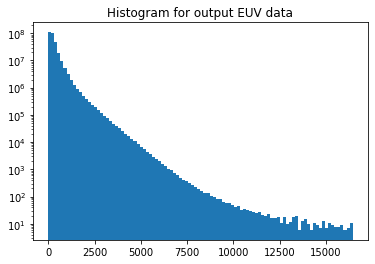

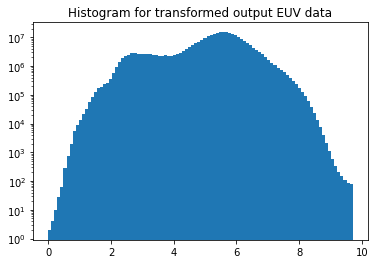

In [5]:
from scipy import stats


transformed_y_arr = np.log(y_arr - np.min(y_arr) + 1)
plt.hist(y_arr, bins=100)
plt.yscale('log', nonposy='clip')
plt.title("Histogram for output EUV data")
plt.show()
plt.hist(transformed_y_arr, bins=100)
plt.yscale('log', nonposy='clip')
plt.title("Histogram for transformed output EUV data")
plt.show()

In [5]:
dl.y_tensor

tensor([[[[ 1.5827e-01,  2.5519e-01,  2.8793e-01,  ...,  3.6752e-01,
            6.2517e-04,  1.4587e-01],
          [ 2.4909e-01,  2.7725e-01,  5.0345e-01,  ...,  8.9266e-02,
            6.7461e-02,  2.6282e-01],
          [ 2.9392e-01,  4.8026e-01,  4.8288e-01,  ...,  8.5044e-01,
            7.3569e-01,  2.8902e-01],
          ...,
          [ 1.0732e-01,  8.0994e-03,  1.0931e-01,  ...,  1.5755e-01,
            4.4018e-01,  1.2796e-01],
          [ 8.7942e-03,  3.3974e-01,  1.8953e-01,  ...,  5.5965e-01,
            5.9870e-02,  2.9914e-01],
          [ 2.6306e-01, -7.1504e-02,  2.4814e-01,  ...,  2.6856e-01,
           -7.3430e-02,  2.4183e-01]]],


        [[[-1.7612e-01,  3.0371e-01,  3.3200e-02,  ..., -1.2398e-01,
           -2.9235e-02,  1.1590e-01],
          [ 3.2982e-01,  2.4902e-01,  2.4339e-01,  ..., -4.4934e-02,
            1.8100e-01,  1.8006e-01],
          [-2.5773e-02,  5.2105e-01, -5.8334e-02,  ...,  2.1227e-01,
            3.6109e-02, -1.1154e-01],
          ...,
   

In [13]:
import numpy as np
mul_val = np.array([5, 6])
test_val = np.ones((2, 6, 6))
print(mul_val.shape)
print(test_val.shape)
print(test_val * mul_val[:, None, None] + mul_val[:, None, None])

(2,)
(2, 6, 6)
[[[10. 10. 10. 10. 10. 10.]
  [10. 10. 10. 10. 10. 10.]
  [10. 10. 10. 10. 10. 10.]
  [10. 10. 10. 10. 10. 10.]
  [10. 10. 10. 10. 10. 10.]
  [10. 10. 10. 10. 10. 10.]]

 [[12. 12. 12. 12. 12. 12.]
  [12. 12. 12. 12. 12. 12.]
  [12. 12. 12. 12. 12. 12.]
  [12. 12. 12. 12. 12. 12.]
  [12. 12. 12. 12. 12. 12.]
  [12. 12. 12. 12. 12. 12.]]]


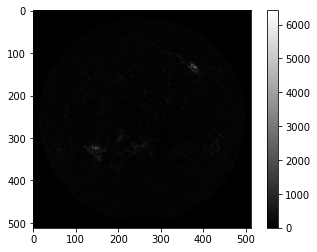

<Figure size 432x288 with 0 Axes>

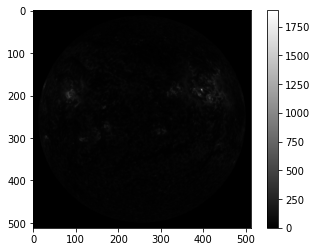

<Figure size 432x288 with 0 Axes>

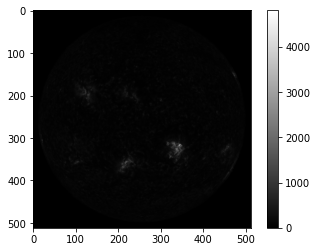

<Figure size 432x288 with 0 Axes>

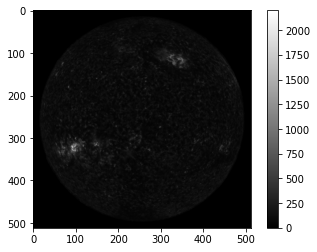

<Figure size 432x288 with 0 Axes>

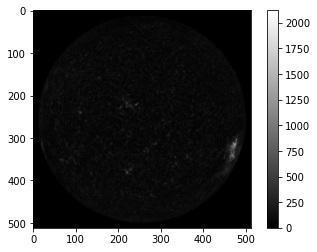

<Figure size 432x288 with 0 Axes>

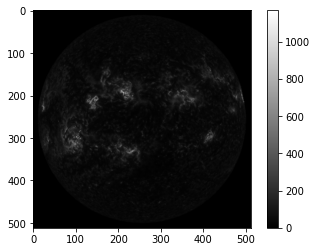

<Figure size 432x288 with 0 Axes>

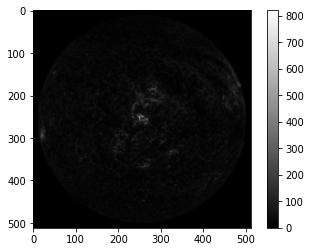

<Figure size 432x288 with 0 Axes>

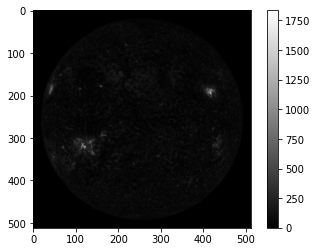

<Figure size 432x288 with 0 Axes>

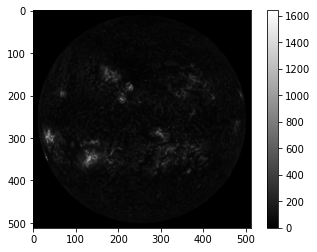

<Figure size 432x288 with 0 Axes>

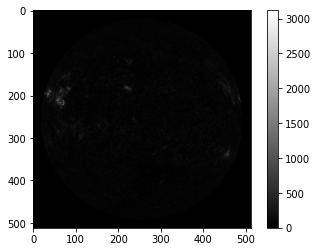

<Figure size 432x288 with 0 Axes>

In [19]:
from skimage.transform import resize

for i in range(10):
    mask = dl.x_data[i, 0, :, :].reshape(512, 512) != 0.0
    data = dl.y_data[i, 0, :, :].reshape(512, 512) * mask
    
    plt.figure()
    plt.imshow(data, cmap='gray')
    plt.colorbar()
    plt.show()
    plt.clf()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


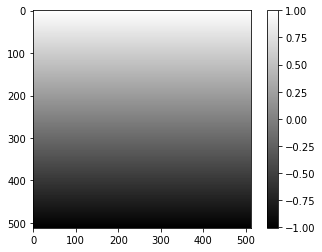

<Figure size 432x288 with 0 Axes>

In [15]:
%load_ext autoreload
%autoreload 2

from transforms import AddLatitudeChannel
import numpy as np

alc = AddLatitudeChannel(['x', 'y'])
test_sample = {'x': np.zeros((1, 512, 512)), 
               'y': np.zeros((1, 512, 512))}
test_sample = alc(test_sample)
plt.figure()
plt.imshow(test_sample['x'][1], cmap='gray')
plt.colorbar()
plt.show()
plt.clf()